### TD/TAB/SARSA

Implement SARSA for estimating 𝑄 ≈ 𝑞∗ and use it to estimate 𝑞∗
for
cliff walking in Exercise gw/cliff.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from random import choice, random, randint
from tqdm import tqdm_notebook as tqdm

In [2]:
class GridCliff:
    
    def __init__(self, h, w):
        self.w = w
        self.h = h
        
        self.actions = [0, 1, 2, 3] #up, down, left, right
        
        self.start = h*w
        self.goal = (h+1)*w-1
        
        self.terminal = [self.goal]
        self.states = [s for s in range(h*w)] + [self.start, self.goal]
        self.cliff = [s for s in range(self.start+1, self.goal)]
        
        self.num_states = h*w + w
        self.num_actions = len(self.actions)
        
        #### state numbering ####
        # 0  1  2  3  4  5 
        # 6  7  8  9  10 11
        # 12 13 14 15 16 17
        # 18 #  #  #  #  23
        
        # 18 and 23 are the final states
        #### state numbering ####
        
    def state_coordinates(self, s):
        return (s // self.w, s % self.w)
        
    def step(self, s, a):
        assert s in (self.states + [self.start, self.goal]), f'{s=} not valid.'
        
        action_values = [-self.w, +self.w, -1, +1]
        sprime = s + action_values[a]
        
        if sprime in self.cliff:
            return self.start, -100
        elif (s // self.w) != (sprime // self.w) and a > 1: # out horizontally
            return s, -1
        elif sprime not in self.states: # out vertically
            return s, -1
        else:
            return sprime, -1

In [3]:
def epsilon_greedy_action(Q, s, ϵ=0.1):
    A = len(Q[s, :])
    
    if random() < ϵ:
        return randint(0, A-1)
    else:
        return Q[s, :].argmax()
    

def sarsa(world, ϵ=0.1, α=0.1, γ=0.9, num_episodes=10, max_steps=100):
    num_A = world.num_actions
    num_S = world.num_states
    
    # Initialize Q
    Q = np.random.random((num_S, num_A))
    for t in world.terminal:
        Q[t] = 0
    for t in world.cliff:
        Q[t] = np.nan
        
    # Loop through episodes
    for ep in tqdm(range(num_episodes)):
        S = choice(world.states) # pick random state
        A = epsilon_greedy_action(Q, S, ϵ=0.1) # ϵ-greedy action
        
        for step in range(max_steps):
            if S in world.terminal: # if S terminal end episode
                break
                
            # step with ϵ-greedy action
            Sprime, R = world.step(S, A)
            Aprime = epsilon_greedy_action(Q, Sprime, ϵ=0.1)
            
            # Update Q
            Q[S, A] = Q[S, A] + α*(R + γ*Q[Sprime, Aprime] - Q[S, A])
            
            # Save current state and action
            S, A = Sprime, Aprime
        
    return Q

In [4]:
h, w = 3, 6

cliff = GridCliff(h, w)

In [5]:
Q_out = sarsa(cliff, ϵ=0.1, α=0.1, γ=1.0, num_episodes=20000, max_steps=1000)

/tmp/ipykernel_152/1607538136.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm(range(num_episodes)):


  0%|          | 0/20000 [00:00<?, ?it/s]

In [6]:
π_greedy = np.ones((cliff.num_states, cliff.num_actions))
for s in cliff.states:
    π_greedy[s] = np.eye(cliff.num_actions)[Q_out[s, :].argmax()] 
    
π_2d = np.ones((h+1, w, 4))
for s in (cliff.states + cliff.cliff):
    s_coord = cliff.state_coordinates(s)
    π_2d[s_coord[0], s_coord[1], :] = π_greedy[s]
for s in cliff.cliff:
    s_coord = cliff.state_coordinates(s)
    π_2d[s_coord[0], s_coord[1], :] = np.nan

V_out = np.ones((h+1, w))
for s in (cliff.states + cliff.cliff):
    s_coord = cliff.state_coordinates(s)
    V_out[s_coord] = (π_greedy*Q_out).sum(axis=-1)[s]
    
print(V_out.round(decimals=2))

[[ -8.86  -7.91  -6.8   -5.72  -4.56  -3.32]
 [ -8.14  -7.17  -6.04  -4.64  -3.48  -2.13]
 [ -9.51  -8.17  -7.08  -6.16  -2.3   -1.  ]
 [-10.9     nan    nan    nan    nan   0.  ]]


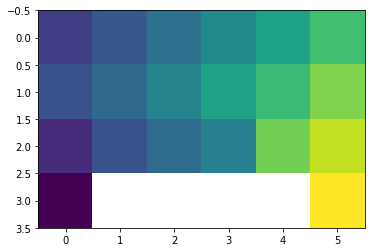

In [7]:
plt.imshow(V_out)

up


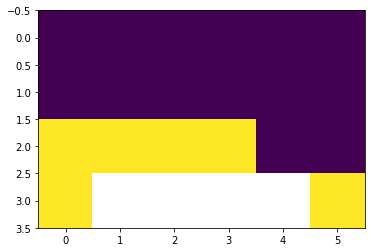

In [8]:
print('up')
plt.imshow(π_2d[:,:,0])

down


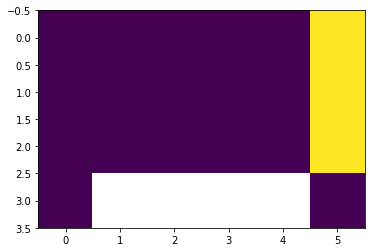

In [9]:
print('down')
plt.imshow(π_2d[:,:,1])

left


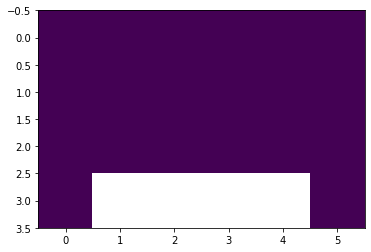

In [10]:
print('left')
plt.imshow(π_2d[:,:,2])

right


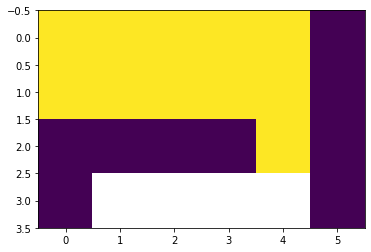

In [11]:
print('right')
plt.imshow(π_2d[:,:,3])

In [12]:
actions = ''
pi_str = ''
for s in range(h*w+w):
    if s % w == 0:
        pi_str += actions + '\n'
        actions = ''
    if s in cliff.cliff:
        actions += '  '
    else:
        actions += ' ' + ['↑', '↓', '←', '→'][π_greedy[s].argmax()]
pi_str += actions + '\n'

print(pi_str)


 → → → → → ↓
 → → → → → ↓
 ↑ ↑ ↑ ↑ → ↓
 ↑         ↑

